
# My experiments with the OpenSlide
## Introduction
Introduce the native-tile API to access OpenSlide. Changes were made to following libraries

###  openslide-python
#### native_tile((x,y), level)

x : x coordinate in pixel space
y : y coordinate in pixel space
level : magnification level in the slide

### openslide
#### openslide_native_tile() : gets the native tile to client
```c
OPENSLIDE_PUBLIC()
void openslide_native_tile(openslide_t *osr,    // [IN] openslide handle
                           uint8_t *dest,       // [OUT] buffer containing native tile
                           int64_t sz,          // [IN] size of the buffer
                           int64_t aligned_x,   // [IN] X aligned to tile boundaries
                           int64_t aligned_y,   // [IN] Y aligned to tile boundaries
                           int32_t level);      // [IN] level
```                          
#### openslide_get_native_tile_data(): returns the size to the client
```c
OPENSLIDE_PUBLIC()
void openslide_get_native_tile_data(openslide_t *osr,   // [IN] openslide handle
                                    int64_t x,          // [IN] X in pixel space
                                    int64_t y,          // [IN] Y in pixel space
                                    int64_t* sz,        // [OUT] tile size
                                    int64_t* aligned_x, // [OUT] aligned X to pixel space
                                    int64_t* aligned_y, // [OUT] algined Y to pixel space
                                    int32_t level);     // [IN] level
```

In [114]:
import openslide
osr = openslide.OpenSlide('../data/tcga.svs')

In [115]:
import pprint
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))
pretty(osr.properties)


aperio.AppMag
	40
aperio.DSR ID
	aperio
aperio.Date
	03/30/15
aperio.DisplayColor
	0
aperio.Exposure Scale
	0.000001
aperio.Exposure Time
	109
aperio.Filename
	TCGA-25-1878_OV337A_PID202_B1_HE
aperio.Focus Offset
	0.000000
aperio.ICC Profile
	ScanScope v1
aperio.ImageID
	23644
aperio.Left
	22.961845
aperio.LineAreaXOffset
	0.012899
aperio.LineAreaYOffset
	0.000790
aperio.LineCameraSkew
	0.001221
aperio.MPP
	0.2523
aperio.OriginalHeight
	66396
aperio.OriginalWidth
	97536
aperio.ScanScope ID
	R0265595
aperio.StripeWidth
	2032
aperio.Time
	23:47:57
aperio.Time Zone
	GMT-05:00
aperio.Top
	18.840120
aperio.User
	c5251699-c268-48b9-b29e-18d0956249c3
openslide.comment
	Aperio Image Library v12.0.15 
97536x66396 [0,100 95663x66296] (240x240) JPEG/RGB Q=70|AppMag = 40|StripeWidth = 2032|ScanScope ID = R0265595|Filename = TCGA-25-1878_OV337A_PID202_B1_HE|Date = 03/30/15|Time = 23:47:57|Time Zone = GMT-05:00|User = c5251699-c268-48b9-b29e-18d0956249c3|MPP = 0.2523|Left = 22.961845|Top = 18.840120

## Visualize the slide
Details on the slide images.
https://portal.gdc.cancer.gov/projects/TCGA-OV

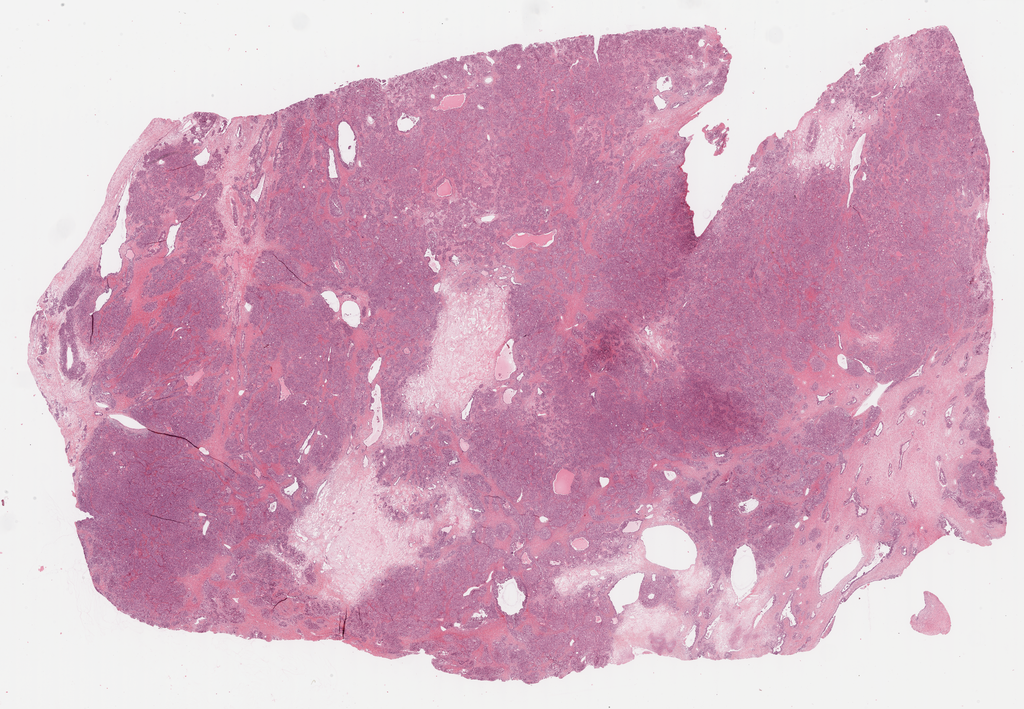

In [84]:
osr.get_thumbnail((1024,1024))

## Experiment : Sanity Check
Compare multiple resolution images between native_tile() and read_region() calls to the slide. This gives visual confirmation that they are same.


Images at tile boundaries
Mean Square Error : 0.0


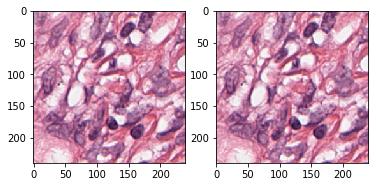

In [116]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from matplotlib import rcParams

%matplotlib inline

# Choosing a factor of 240 in both dimension as its at tile boundaries
def compare_images(x, y, level):
    tw = int(osr.properties['openslide.level['+str(level)+'].tile-width'])
    th = int(osr.properties['openslide.level['+str(level)+'].tile-height'])    
    im_native = osr.native_tile(((x // tw)*tw, (y // th)*th), 0)
    im_read = osr.read_region(((x // tw)*tw, (y // th)*th), 0, (tw,th))
    im_read2 = osr.read_region((x, y), 0, (tw,th))
    return im_native, im_read, im_read2

def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

# display images
im_native, im_read, im_read2 = compare_images(40000, 30000, 0)

fig, ax = plt.subplots(1,2)
print ("Images at tile boundaries")
print ("Mean Square Error : {}".format(mse(np.array(im_native.convert('RGB')), np.array(im_read.convert('RGB')))))
ax[0].imshow(im_native);
ax[1].imshow(im_read);

Images at non-tile boundaries
Mean Square Error : 11268.610121527778


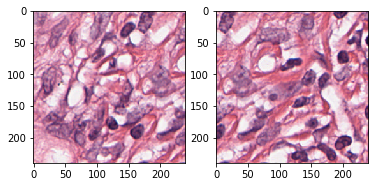

In [117]:
print ("Images at non-tile boundaries")
print ("Mean Square Error : {}".format(mse(np.array(im_native.convert('RGB')), np.array(im_read2.convert('RGB')))))
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_native);
ax[1].imshow(im_read2);

## Experiment : Different resolutions
This is to confirm that the native tiling logic works at different magnification levels

Mean Square Error : 0.0


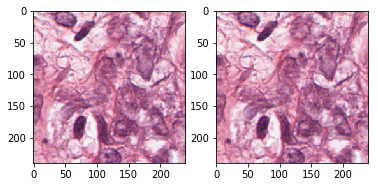

In [118]:
# display images
fig, ax = plt.subplots(1,2)
im_native, im_read, _ = compare_images(20000, 15000, 1)
print ("Mean Square Error : {}".format(mse(np.array(im_native.convert('RGB')), np.array(im_read.convert('RGB')))))
ax[0].imshow(im_native);
ax[1].imshow(im_read);

## Experiment : Performance comparison
Compares the performance of extracting native patches vs read_region call from random grid of patches

In [119]:
# sample the calls from both read_region and compare with native_tile
import random
random.seed(231)
level = 0
NUM_PATCHES = 300
w,h = osr.level_dimensions[0]
tw = int(osr.properties['openslide.level['+str(level)+'].tile-width'])
th = int(osr.properties['openslide.level['+str(level)+'].tile-height'])   

def samplegrid(w, h, n):
    return [divmod(i, h) for i in random.sample(range((w-tw) * (h-th)), n)]

samples = samplegrid(w, h, NUM_PATCHES)

In [120]:
import time

start = time.time()
im_native = []
im_read = []
tw = int(osr.properties['openslide.level['+str(level)+'].tile-width'])
th = int(osr.properties['openslide.level['+str(level)+'].tile-height'])    
for s in samples :
    im = osr.native_tile((s[0], s[1]), level).convert('RGB')
    im_native.append(im)
end = time.time()
time_native = end - start
start = time.time()
for s in samples :
    im = osr.read_region((s[0], s[1]), level, (tw, th)).convert('RGB')
    im_read.append(im)
end = time.time()
time_region = end - start
print ("Time for native_tile: {} and time for read_region: {}".format(time_native, time_region))
print ("Speedup is : {}".format((NUM_PATCHES/time_native - NUM_PATCHES/time_region)/(NUM_PATCHES/time_region)))

Time for native_tile: 0.6034760475158691 and time for read_region: 2.2153639793395996
Speedup is : 2.6710056487889755


## Experiment : Performance comparison at tile boundaries
This calculates x,y coordinates for tile boundaries and then queries the read_region call.


In [121]:
start = time.time()
im_native = []
im_read = []

for s in samples :
    im = osr.native_tile(((s[0]//tw)*tw, (s[1]//th)*th), level).convert('RGB')
    im_native.append(im)
end = time.time()
time_native = end - start
start = time.time()
for s in samples :
    im = osr.read_region(((s[0]//tw)*tw, (s[1]//th)*th), 0, (240, 240)).convert('RGB')
    im_read.append(im)
end = time.time()
time_region = end - start
print ("Time for native_tile: {} and time for read_region: {}".format(time_native, time_region))
print ("Speedup is : {}".format((NUM_PATCHES/time_native - NUM_PATCHES/time_region)/(NUM_PATCHES/time_region)))

Time for native_tile: 0.44869494438171387 and time for read_region: 0.805431604385376
Speedup is : 0.7950538878819615
